In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_processed.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_processed.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_processed.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
breaking_ball = data.query('pitch_type_condensed in ("CH", "")')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("FF", "SI")')

# Fastball Model First

In [5]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball', 'line_drive',
    'total_movement'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball', 'line_drive',
    'total_movement', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [6]:
train_data = training_features.drop(['swing'], axis=1).copy()
train_label = training_features['swing'].copy()
testing_data = testing_features.drop(['swing'], axis=1).copy()
testing_label = testing_features['swing'].copy()

In [7]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo'],
      dtype='object')

In [8]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo'],
      dtype='object')

In [9]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [10]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [11]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6720488225393741
Log Loss: 0.6200689054362148


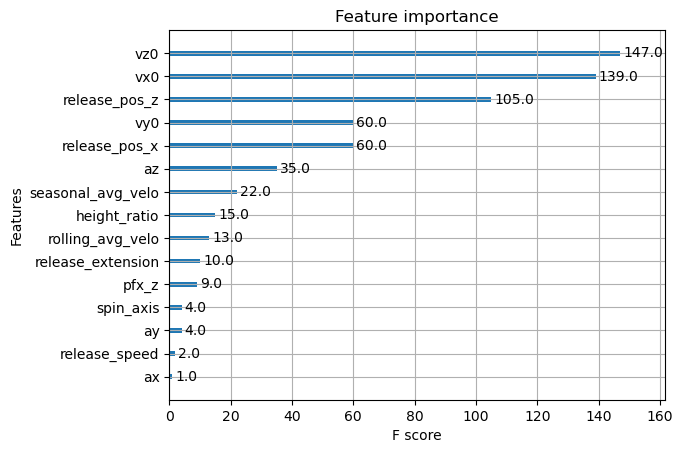

In [12]:
xgb.plot_importance(model)
plt.show()

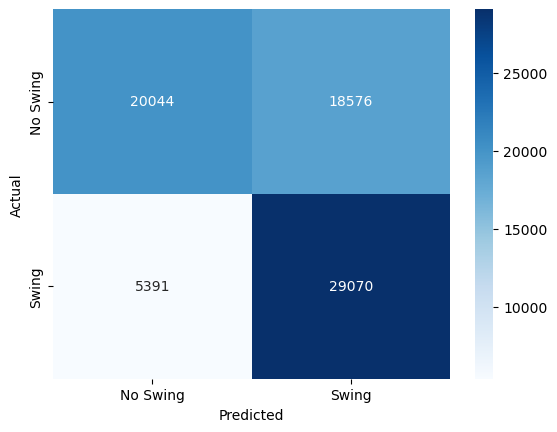

In [13]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [14]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'device' : 'gpu',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [15]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-14 18:37:38,747] A new study created in memory with name: no-name-9a6fe6b5-fde6-424a-b791-7bcc5260182d


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68714
[2]	eval-logloss:0.68444
[3]	eval-logloss:0.68149
[4]	eval-logloss:0.67864
[5]	eval-logloss:0.67621
[6]	eval-logloss:0.67405
[7]	eval-logloss:0.67167
[8]	eval-logloss:0.66952
[9]	eval-logloss:0.66733
[10]	eval-logloss:0.66531
[11]	eval-logloss:0.66284
[12]	eval-logloss:0.66188
[13]	eval-logloss:0.66006
[14]	eval-logloss:0.65813
[15]	eval-logloss:0.65633
[16]	eval-logloss:0.65399
[17]	eval-logloss:0.65234
[18]	eval-logloss:0.65002
[19]	eval-logloss:0.64826
[20]	eval-logloss:0.64636
[21]	eval-logloss:0.64498
[22]	eval-logloss:0.64350
[23]	eval-logloss:0.64184
[24]	eval-logloss:0.64045
[25]	eval-logloss:0.63921
[26]	eval-logloss:0.63908
[27]	eval-logloss:0.63896
[28]	eval-logloss:0.63818
[29]	eval-logloss:0.63652
[30]	eval-logloss:0.63533
[31]	eval-logloss:0.63448
[32]	eval-logloss:0.63380
[33]	eval-logloss:0.63269
[34]	eval-logloss:0.63145
[35]	eval-logloss:0.63026
[36]	eval-logloss:0.62880
[37]	eval-logloss:0.62775
[38]	eval-logloss:0.62

[I 2023-11-14 18:37:40,403] Trial 0 finished with value: 0.587033401656211 and parameters: {'max_depth': 6, 'eta': 0.02559158406807878, 'subsample': 0.7017884844730303, 'colsample_bytree': 0.6875751341978541}. Best is trial 0 with value: 0.587033401656211.


[0]	eval-logloss:0.68167
[1]	eval-logloss:0.67091
[2]	eval-logloss:0.66340
[3]	eval-logloss:0.65486
[4]	eval-logloss:0.64597
[5]	eval-logloss:0.64021
[6]	eval-logloss:0.63395
[7]	eval-logloss:0.62795
[8]	eval-logloss:0.62250
[9]	eval-logloss:0.61855
[10]	eval-logloss:0.61315
[11]	eval-logloss:0.60895
[12]	eval-logloss:0.60495
[13]	eval-logloss:0.60108
[14]	eval-logloss:0.59744
[15]	eval-logloss:0.59395
[16]	eval-logloss:0.59091
[17]	eval-logloss:0.58823
[18]	eval-logloss:0.58588
[19]	eval-logloss:0.58269
[20]	eval-logloss:0.58037
[21]	eval-logloss:0.57868
[22]	eval-logloss:0.57692
[23]	eval-logloss:0.57461
[24]	eval-logloss:0.57321
[25]	eval-logloss:0.57100
[26]	eval-logloss:0.56980
[27]	eval-logloss:0.56693
[28]	eval-logloss:0.56581
[29]	eval-logloss:0.56456
[30]	eval-logloss:0.56325
[31]	eval-logloss:0.56246
[32]	eval-logloss:0.56029
[33]	eval-logloss:0.55913
[34]	eval-logloss:0.55808
[35]	eval-logloss:0.55720
[36]	eval-logloss:0.55651
[37]	eval-logloss:0.55580
[38]	eval-logloss:0.55

[I 2023-11-14 18:37:42,288] Trial 1 finished with value: 0.5232661531889933 and parameters: {'max_depth': 8, 'eta': 0.07497615968012265, 'subsample': 0.6514260350953611, 'colsample_bytree': 0.9717085290133541}. Best is trial 1 with value: 0.5232661531889933.


[0]	eval-logloss:0.68922
[1]	eval-logloss:0.65209
[2]	eval-logloss:0.63169
[3]	eval-logloss:0.60891
[4]	eval-logloss:0.59713
[5]	eval-logloss:0.59107
[6]	eval-logloss:0.58798
[7]	eval-logloss:0.57584
[8]	eval-logloss:0.56644
[9]	eval-logloss:0.56117
[10]	eval-logloss:0.56036
[11]	eval-logloss:0.55778
[12]	eval-logloss:0.55639
[13]	eval-logloss:0.55411
[14]	eval-logloss:0.55103
[15]	eval-logloss:0.54940
[16]	eval-logloss:0.54752
[17]	eval-logloss:0.54600
[18]	eval-logloss:0.54487
[19]	eval-logloss:0.53969
[20]	eval-logloss:0.53919
[21]	eval-logloss:0.53861
[22]	eval-logloss:0.53828
[23]	eval-logloss:0.53831
[24]	eval-logloss:0.53800
[25]	eval-logloss:0.53802
[26]	eval-logloss:0.53799
[27]	eval-logloss:0.53808
[28]	eval-logloss:0.53811
[29]	eval-logloss:0.53374
[30]	eval-logloss:0.53302
[31]	eval-logloss:0.53292
[32]	eval-logloss:0.53221
[33]	eval-logloss:0.53210
[34]	eval-logloss:0.53214
[35]	eval-logloss:0.53219
[36]	eval-logloss:0.52901
[37]	eval-logloss:0.52914
[38]	eval-logloss:0.52

[I 2023-11-14 18:37:43,988] Trial 2 finished with value: 0.5196815763535425 and parameters: {'max_depth': 8, 'eta': 0.2947303899247321, 'subsample': 0.8212151514499276, 'colsample_bytree': 0.5812515609605677}. Best is trial 2 with value: 0.5196815763535425.


[0]	eval-logloss:0.66444
[1]	eval-logloss:0.63553
[2]	eval-logloss:0.62249
[3]	eval-logloss:0.60452
[4]	eval-logloss:0.59119
[5]	eval-logloss:0.58420
[6]	eval-logloss:0.57417
[7]	eval-logloss:0.56897
[8]	eval-logloss:0.55977
[9]	eval-logloss:0.55656
[10]	eval-logloss:0.55315
[11]	eval-logloss:0.55102
[12]	eval-logloss:0.54984
[13]	eval-logloss:0.54838
[14]	eval-logloss:0.54742
[15]	eval-logloss:0.54525
[16]	eval-logloss:0.53951
[17]	eval-logloss:0.53621
[18]	eval-logloss:0.53424
[19]	eval-logloss:0.53265
[20]	eval-logloss:0.53136
[21]	eval-logloss:0.53075
[22]	eval-logloss:0.53056
[23]	eval-logloss:0.52812
[24]	eval-logloss:0.52790
[25]	eval-logloss:0.52542
[26]	eval-logloss:0.52387
[27]	eval-logloss:0.52392
[28]	eval-logloss:0.52375
[29]	eval-logloss:0.52345
[30]	eval-logloss:0.52230
[31]	eval-logloss:0.52141
[32]	eval-logloss:0.52120
[33]	eval-logloss:0.52105
[34]	eval-logloss:0.52098
[35]	eval-logloss:0.52106
[36]	eval-logloss:0.52050
[37]	eval-logloss:0.52051
[38]	eval-logloss:0.52

[I 2023-11-14 18:37:46,142] Trial 3 finished with value: 0.5150046550523201 and parameters: {'max_depth': 9, 'eta': 0.23629828127575087, 'subsample': 0.837001207742024, 'colsample_bytree': 0.8120098996768832}. Best is trial 3 with value: 0.5150046550523201.


[0]	eval-logloss:0.68858
[1]	eval-logloss:0.68438
[2]	eval-logloss:0.68082
[3]	eval-logloss:0.67715
[4]	eval-logloss:0.67394
[5]	eval-logloss:0.67071
[6]	eval-logloss:0.66757
[7]	eval-logloss:0.66498
[8]	eval-logloss:0.66212
[9]	eval-logloss:0.65984
[10]	eval-logloss:0.65747
[11]	eval-logloss:0.65505
[12]	eval-logloss:0.65327
[13]	eval-logloss:0.65121
[14]	eval-logloss:0.64918
[15]	eval-logloss:0.64699
[16]	eval-logloss:0.64557
[17]	eval-logloss:0.64389
[18]	eval-logloss:0.64218
[19]	eval-logloss:0.64070
[20]	eval-logloss:0.63890
[21]	eval-logloss:0.63777
[22]	eval-logloss:0.63672
[23]	eval-logloss:0.63510
[24]	eval-logloss:0.63372
[25]	eval-logloss:0.63285
[26]	eval-logloss:0.63159
[27]	eval-logloss:0.62965
[28]	eval-logloss:0.62840
[29]	eval-logloss:0.62767
[30]	eval-logloss:0.62645
[31]	eval-logloss:0.62573
[32]	eval-logloss:0.62460
[33]	eval-logloss:0.62342
[34]	eval-logloss:0.62282
[35]	eval-logloss:0.62185
[36]	eval-logloss:0.62064
[37]	eval-logloss:0.61988
[38]	eval-logloss:0.61

[I 2023-11-14 18:37:47,130] Trial 4 finished with value: 0.5847230708231782 and parameters: {'max_depth': 4, 'eta': 0.04862666605378902, 'subsample': 0.8673940604904036, 'colsample_bytree': 0.9784022491673321}. Best is trial 3 with value: 0.5150046550523201.


[0]	eval-logloss:0.68733
[1]	eval-logloss:0.68156
[2]	eval-logloss:0.67673
[3]	eval-logloss:0.67173
[4]	eval-logloss:0.66716
[5]	eval-logloss:0.66356
[6]	eval-logloss:0.66032
[7]	eval-logloss:0.65617
[8]	eval-logloss:0.65256
[9]	eval-logloss:0.64972
[10]	eval-logloss:0.64684
[11]	eval-logloss:0.64385
[12]	eval-logloss:0.64233
[13]	eval-logloss:0.63996
[14]	eval-logloss:0.63775
[15]	eval-logloss:0.63475
[16]	eval-logloss:0.63222
[17]	eval-logloss:0.63024
[18]	eval-logloss:0.62808
[19]	eval-logloss:0.62601
[20]	eval-logloss:0.62382
[21]	eval-logloss:0.62238
[22]	eval-logloss:0.62087
[23]	eval-logloss:0.61911
[24]	eval-logloss:0.61742
[25]	eval-logloss:0.61615
[26]	eval-logloss:0.61591
[27]	eval-logloss:0.61577
[28]	eval-logloss:0.61469
[29]	eval-logloss:0.61288
[30]	eval-logloss:0.61153
[31]	eval-logloss:0.61067
[32]	eval-logloss:0.60970
[33]	eval-logloss:0.60857
[34]	eval-logloss:0.60743
[35]	eval-logloss:0.60629
[36]	eval-logloss:0.60562
[37]	eval-logloss:0.60463
[38]	eval-logloss:0.60

[I 2023-11-14 18:37:48,229] Trial 5 finished with value: 0.5682048913967924 and parameters: {'max_depth': 5, 'eta': 0.05646819053260965, 'subsample': 0.6448006417622516, 'colsample_bytree': 0.6726022047569726}. Best is trial 3 with value: 0.5150046550523201.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.66755
[2]	eval-logloss:0.65865
[3]	eval-logloss:0.64762
[4]	eval-logloss:0.63913
[5]	eval-logloss:0.63313
[6]	eval-logloss:0.62715
[7]	eval-logloss:0.62178
[8]	eval-logloss:0.61464
[9]	eval-logloss:0.61002
[10]	eval-logloss:0.60484
[11]	eval-logloss:0.60070
[12]	eval-logloss:0.59880
[13]	eval-logloss:0.59615
[14]	eval-logloss:0.59349
[15]	eval-logloss:0.59001
[16]	eval-logloss:0.58719
[17]	eval-logloss:0.58473
[18]	eval-logloss:0.58258
[19]	eval-logloss:0.58102
[20]	eval-logloss:0.57808
[21]	eval-logloss:0.57672
[22]	eval-logloss:0.57516
[23]	eval-logloss:0.57256
[24]	eval-logloss:0.57152
[25]	eval-logloss:0.56880
[26]	eval-logloss:0.56640
[27]	eval-logloss:0.56631
[28]	eval-logloss:0.56545
[29]	eval-logloss:0.56437
[30]	eval-logloss:0.56267
[31]	eval-logloss:0.56129
[32]	eval-logloss:0.56045
[33]	eval-logloss:0.55983
[34]	eval-logloss:0.55892
[35]	eval-logloss:0.55799
[36]	eval-logloss:0.55734
[37]	eval-logloss:0.55692
[38]	eval-logloss:0.55

[I 2023-11-14 18:37:49,693] Trial 6 finished with value: 0.5243694108361124 and parameters: {'max_depth': 7, 'eta': 0.10470278858945221, 'subsample': 0.660427132469977, 'colsample_bytree': 0.7926705752591052}. Best is trial 3 with value: 0.5150046550523201.


[0]	eval-logloss:0.68923
[1]	eval-logloss:0.68515
[2]	eval-logloss:0.68182
[3]	eval-logloss:0.67841
[4]	eval-logloss:0.67537
[5]	eval-logloss:0.67265
[6]	eval-logloss:0.67020
[7]	eval-logloss:0.66785
[8]	eval-logloss:0.66580
[9]	eval-logloss:0.66375
[10]	eval-logloss:0.66146
[11]	eval-logloss:0.65973
[12]	eval-logloss:0.65894
[13]	eval-logloss:0.65740
[14]	eval-logloss:0.65593
[15]	eval-logloss:0.65390
[16]	eval-logloss:0.65241
[17]	eval-logloss:0.65097
[18]	eval-logloss:0.64959
[19]	eval-logloss:0.64796
[20]	eval-logloss:0.64701
[21]	eval-logloss:0.64616
[22]	eval-logloss:0.64530
[23]	eval-logloss:0.64510
[24]	eval-logloss:0.64389
[25]	eval-logloss:0.64369
[26]	eval-logloss:0.64350
[27]	eval-logloss:0.64333
[28]	eval-logloss:0.64318
[29]	eval-logloss:0.64124
[30]	eval-logloss:0.64050
[31]	eval-logloss:0.63989
[32]	eval-logloss:0.63907
[33]	eval-logloss:0.63802
[34]	eval-logloss:0.63788
[35]	eval-logloss:0.63725
[36]	eval-logloss:0.63635
[37]	eval-logloss:0.63620
[38]	eval-logloss:0.63

[I 2023-11-14 18:37:50,583] Trial 7 finished with value: 0.6080738292935991 and parameters: {'max_depth': 3, 'eta': 0.05751155624789351, 'subsample': 0.6898169366575707, 'colsample_bytree': 0.6175585177591136}. Best is trial 3 with value: 0.5150046550523201.


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.68906
[2]	eval-logloss:0.68742
[3]	eval-logloss:0.68550
[4]	eval-logloss:0.68351
[5]	eval-logloss:0.68180
[6]	eval-logloss:0.67995
[7]	eval-logloss:0.67814
[8]	eval-logloss:0.67635
[9]	eval-logloss:0.67476
[10]	eval-logloss:0.67306
[11]	eval-logloss:0.67124
[12]	eval-logloss:0.66938
[13]	eval-logloss:0.66765
[14]	eval-logloss:0.66594
[15]	eval-logloss:0.66428
[16]	eval-logloss:0.66275
[17]	eval-logloss:0.66129
[18]	eval-logloss:0.65971
[19]	eval-logloss:0.65831
[20]	eval-logloss:0.65681
[21]	eval-logloss:0.65525
[22]	eval-logloss:0.65378
[23]	eval-logloss:0.65242
[24]	eval-logloss:0.65115
[25]	eval-logloss:0.64994
[26]	eval-logloss:0.64844
[27]	eval-logloss:0.64728
[28]	eval-logloss:0.64608
[29]	eval-logloss:0.64479
[30]	eval-logloss:0.64373
[31]	eval-logloss:0.64248
[32]	eval-logloss:0.64136
[33]	eval-logloss:0.64003
[34]	eval-logloss:0.63893
[35]	eval-logloss:0.63775
[36]	eval-logloss:0.63653
[37]	eval-logloss:0.63558
[38]	eval-logloss:0.63

[I 2023-11-14 18:37:52,550] Trial 8 finished with value: 0.5893661523586285 and parameters: {'max_depth': 8, 'eta': 0.013225883522849768, 'subsample': 0.7946083285857098, 'colsample_bytree': 0.9737446179466942}. Best is trial 3 with value: 0.5150046550523201.


[0]	eval-logloss:0.66241
[1]	eval-logloss:0.63809
[2]	eval-logloss:0.62442
[3]	eval-logloss:0.60751
[4]	eval-logloss:0.59537
[5]	eval-logloss:0.58889
[6]	eval-logloss:0.58124
[7]	eval-logloss:0.57522
[8]	eval-logloss:0.57012
[9]	eval-logloss:0.56697
[10]	eval-logloss:0.56341
[11]	eval-logloss:0.55690
[12]	eval-logloss:0.55298
[13]	eval-logloss:0.54921
[14]	eval-logloss:0.54767
[15]	eval-logloss:0.54579
[16]	eval-logloss:0.54439
[17]	eval-logloss:0.54085
[18]	eval-logloss:0.53952
[19]	eval-logloss:0.53820
[20]	eval-logloss:0.53707
[21]	eval-logloss:0.53627
[22]	eval-logloss:0.53344
[23]	eval-logloss:0.53042
[24]	eval-logloss:0.52899
[25]	eval-logloss:0.52820
[26]	eval-logloss:0.52708
[27]	eval-logloss:0.52669
[28]	eval-logloss:0.52615
[29]	eval-logloss:0.52525
[30]	eval-logloss:0.52495
[31]	eval-logloss:0.52467
[32]	eval-logloss:0.52336
[33]	eval-logloss:0.52312
[34]	eval-logloss:0.52312
[35]	eval-logloss:0.52294
[36]	eval-logloss:0.52247
[37]	eval-logloss:0.52250
[38]	eval-logloss:0.52

[I 2023-11-14 18:37:54,772] Trial 9 finished with value: 0.5140696936780025 and parameters: {'max_depth': 9, 'eta': 0.19426517051918368, 'subsample': 0.6393955060368319, 'colsample_bytree': 0.9491973720554978}. Best is trial 9 with value: 0.5140696936780025.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.66431
[2]	eval-logloss:0.64827
[3]	eval-logloss:0.63146
[4]	eval-logloss:0.62513
[5]	eval-logloss:0.61634
[6]	eval-logloss:0.61172
[7]	eval-logloss:0.59950
[8]	eval-logloss:0.59025
[9]	eval-logloss:0.58385
[10]	eval-logloss:0.58339
[11]	eval-logloss:0.57766
[12]	eval-logloss:0.57571
[13]	eval-logloss:0.57191
[14]	eval-logloss:0.56466
[15]	eval-logloss:0.56180
[16]	eval-logloss:0.56009
[17]	eval-logloss:0.55656
[18]	eval-logloss:0.55404
[19]	eval-logloss:0.54955
[20]	eval-logloss:0.54755
[21]	eval-logloss:0.54609
[22]	eval-logloss:0.54571
[23]	eval-logloss:0.54563
[24]	eval-logloss:0.54425
[25]	eval-logloss:0.54426
[26]	eval-logloss:0.54414
[27]	eval-logloss:0.54414
[28]	eval-logloss:0.54413
[29]	eval-logloss:0.53966
[30]	eval-logloss:0.53895
[31]	eval-logloss:0.53870
[32]	eval-logloss:0.53815
[33]	eval-logloss:0.53805
[34]	eval-logloss:0.53806
[35]	eval-logloss:0.53708
[36]	eval-logloss:0.53478
[37]	eval-logloss:0.53470
[38]	eval-logloss:0.53

[I 2023-11-14 18:37:56,920] Trial 10 finished with value: 0.5197180339809716 and parameters: {'max_depth': 9, 'eta': 0.16809914277670093, 'subsample': 0.6158310390539377, 'colsample_bytree': 0.5039012621144571}. Best is trial 9 with value: 0.5140696936780025.


[0]	eval-logloss:0.66752
[1]	eval-logloss:0.64010
[2]	eval-logloss:0.62752
[3]	eval-logloss:0.60933
[4]	eval-logloss:0.59550
[5]	eval-logloss:0.58813
[6]	eval-logloss:0.57807
[7]	eval-logloss:0.57236
[8]	eval-logloss:0.56242
[9]	eval-logloss:0.55934
[10]	eval-logloss:0.55612
[11]	eval-logloss:0.55233
[12]	eval-logloss:0.54978
[13]	eval-logloss:0.54713
[14]	eval-logloss:0.54477
[15]	eval-logloss:0.54220
[16]	eval-logloss:0.53938
[17]	eval-logloss:0.53802
[18]	eval-logloss:0.53651
[19]	eval-logloss:0.53348
[20]	eval-logloss:0.53219
[21]	eval-logloss:0.53145
[22]	eval-logloss:0.53092
[23]	eval-logloss:0.53049
[24]	eval-logloss:0.53025
[25]	eval-logloss:0.52898
[26]	eval-logloss:0.52581
[27]	eval-logloss:0.52578
[28]	eval-logloss:0.52534
[29]	eval-logloss:0.52395
[30]	eval-logloss:0.52277
[31]	eval-logloss:0.52194
[32]	eval-logloss:0.52190
[33]	eval-logloss:0.52196
[34]	eval-logloss:0.52188
[35]	eval-logloss:0.52088
[36]	eval-logloss:0.52056
[37]	eval-logloss:0.52064
[38]	eval-logloss:0.51

[I 2023-11-14 18:37:59,195] Trial 11 finished with value: 0.5142427438785374 and parameters: {'max_depth': 9, 'eta': 0.2130093434183823, 'subsample': 0.7462867768758144, 'colsample_bytree': 0.8499880150635897}. Best is trial 9 with value: 0.5140696936780025.


[0]	eval-logloss:0.67090
[1]	eval-logloss:0.64626
[2]	eval-logloss:0.63410
[3]	eval-logloss:0.61718
[4]	eval-logloss:0.60348
[5]	eval-logloss:0.59602
[6]	eval-logloss:0.58709
[7]	eval-logloss:0.58098
[8]	eval-logloss:0.57158
[9]	eval-logloss:0.56767
[10]	eval-logloss:0.56416
[11]	eval-logloss:0.55876
[12]	eval-logloss:0.55666
[13]	eval-logloss:0.55433
[14]	eval-logloss:0.55209
[15]	eval-logloss:0.54926
[16]	eval-logloss:0.54747
[17]	eval-logloss:0.54539
[18]	eval-logloss:0.54392
[19]	eval-logloss:0.54145
[20]	eval-logloss:0.54004
[21]	eval-logloss:0.53851
[22]	eval-logloss:0.53797
[23]	eval-logloss:0.53482
[24]	eval-logloss:0.53434
[25]	eval-logloss:0.53272
[26]	eval-logloss:0.53191
[27]	eval-logloss:0.53169
[28]	eval-logloss:0.53084
[29]	eval-logloss:0.52919
[30]	eval-logloss:0.52877
[31]	eval-logloss:0.52863
[32]	eval-logloss:0.52849
[33]	eval-logloss:0.52837
[34]	eval-logloss:0.52814
[35]	eval-logloss:0.52751
[36]	eval-logloss:0.52707
[37]	eval-logloss:0.52702
[38]	eval-logloss:0.52

[I 2023-11-14 18:38:01,537] Trial 12 finished with value: 0.5131479977504663 and parameters: {'max_depth': 9, 'eta': 0.1821640133009545, 'subsample': 0.7427303526326495, 'colsample_bytree': 0.8664556577340934}. Best is trial 12 with value: 0.5131479977504663.


[0]	eval-logloss:0.67280
[1]	eval-logloss:0.65655
[2]	eval-logloss:0.64557
[3]	eval-logloss:0.63237
[4]	eval-logloss:0.62235
[5]	eval-logloss:0.61628
[6]	eval-logloss:0.60837
[7]	eval-logloss:0.60321
[8]	eval-logloss:0.59822
[9]	eval-logloss:0.59457
[10]	eval-logloss:0.59218
[11]	eval-logloss:0.58897
[12]	eval-logloss:0.58540
[13]	eval-logloss:0.57927
[14]	eval-logloss:0.57503
[15]	eval-logloss:0.57218
[16]	eval-logloss:0.56999
[17]	eval-logloss:0.56797
[18]	eval-logloss:0.56613
[19]	eval-logloss:0.56358
[20]	eval-logloss:0.56061
[21]	eval-logloss:0.55958
[22]	eval-logloss:0.55859
[23]	eval-logloss:0.55501
[24]	eval-logloss:0.55425
[25]	eval-logloss:0.55315
[26]	eval-logloss:0.55117
[27]	eval-logloss:0.55084
[28]	eval-logloss:0.55003
[29]	eval-logloss:0.54829
[30]	eval-logloss:0.54769
[31]	eval-logloss:0.54702
[32]	eval-logloss:0.54544
[33]	eval-logloss:0.54452
[34]	eval-logloss:0.54366
[35]	eval-logloss:0.54307
[36]	eval-logloss:0.54219
[37]	eval-logloss:0.54200
[38]	eval-logloss:0.54

[I 2023-11-14 18:38:03,033] Trial 13 finished with value: 0.5177854699500447 and parameters: {'max_depth': 7, 'eta': 0.14796807265925066, 'subsample': 0.6002160905658739, 'colsample_bytree': 0.8904084220627203}. Best is trial 12 with value: 0.5131479977504663.


[0]	eval-logloss:0.67189
[1]	eval-logloss:0.65451
[2]	eval-logloss:0.64264
[3]	eval-logloss:0.63139
[4]	eval-logloss:0.62244
[5]	eval-logloss:0.61628
[6]	eval-logloss:0.60816
[7]	eval-logloss:0.60074
[8]	eval-logloss:0.59637
[9]	eval-logloss:0.59280
[10]	eval-logloss:0.58774
[11]	eval-logloss:0.58372
[12]	eval-logloss:0.58068
[13]	eval-logloss:0.57817
[14]	eval-logloss:0.57677
[15]	eval-logloss:0.57203
[16]	eval-logloss:0.57059
[17]	eval-logloss:0.56511
[18]	eval-logloss:0.56080
[19]	eval-logloss:0.55878
[20]	eval-logloss:0.55653
[21]	eval-logloss:0.55529
[22]	eval-logloss:0.55431
[23]	eval-logloss:0.55309
[24]	eval-logloss:0.55216
[25]	eval-logloss:0.54989
[26]	eval-logloss:0.54894
[27]	eval-logloss:0.54860
[28]	eval-logloss:0.54743
[29]	eval-logloss:0.54554
[30]	eval-logloss:0.54363
[31]	eval-logloss:0.54314
[32]	eval-logloss:0.54163
[33]	eval-logloss:0.54026
[34]	eval-logloss:0.53973
[35]	eval-logloss:0.53806
[36]	eval-logloss:0.53766
[37]	eval-logloss:0.53744
[38]	eval-logloss:0.53

[I 2023-11-14 18:38:04,517] Trial 14 finished with value: 0.5159817896314297 and parameters: {'max_depth': 7, 'eta': 0.15839502257829882, 'subsample': 0.7428438753143274, 'colsample_bytree': 0.8889006149002939}. Best is trial 12 with value: 0.5131479977504663.


[0]	eval-logloss:0.66975
[1]	eval-logloss:0.64987
[2]	eval-logloss:0.63724
[3]	eval-logloss:0.62739
[4]	eval-logloss:0.61753
[5]	eval-logloss:0.61194
[6]	eval-logloss:0.60461
[7]	eval-logloss:0.59897
[8]	eval-logloss:0.59465
[9]	eval-logloss:0.59170
[10]	eval-logloss:0.58441
[11]	eval-logloss:0.58034
[12]	eval-logloss:0.57686
[13]	eval-logloss:0.57358
[14]	eval-logloss:0.57178
[15]	eval-logloss:0.56929
[16]	eval-logloss:0.56784
[17]	eval-logloss:0.56444
[18]	eval-logloss:0.56233
[19]	eval-logloss:0.56110
[20]	eval-logloss:0.56011
[21]	eval-logloss:0.55932
[22]	eval-logloss:0.55835
[23]	eval-logloss:0.55346
[24]	eval-logloss:0.55286
[25]	eval-logloss:0.55244
[26]	eval-logloss:0.55077
[27]	eval-logloss:0.55049
[28]	eval-logloss:0.54996
[29]	eval-logloss:0.54860
[30]	eval-logloss:0.54727
[31]	eval-logloss:0.54501
[32]	eval-logloss:0.54344
[33]	eval-logloss:0.54325
[34]	eval-logloss:0.54284
[35]	eval-logloss:0.54189
[36]	eval-logloss:0.54099
[37]	eval-logloss:0.54040
[38]	eval-logloss:0.53

[I 2023-11-14 18:38:05,803] Trial 15 finished with value: 0.5175534621485534 and parameters: {'max_depth': 6, 'eta': 0.2037583019487961, 'subsample': 0.7221827983749213, 'colsample_bytree': 0.9157126109972997}. Best is trial 12 with value: 0.5131479977504663.


[0]	eval-logloss:0.67803
[1]	eval-logloss:0.66004
[2]	eval-logloss:0.64969
[3]	eval-logloss:0.63619
[4]	eval-logloss:0.62546
[5]	eval-logloss:0.61778
[6]	eval-logloss:0.61210
[7]	eval-logloss:0.60466
[8]	eval-logloss:0.59677
[9]	eval-logloss:0.59223
[10]	eval-logloss:0.58856
[11]	eval-logloss:0.58277
[12]	eval-logloss:0.58065
[13]	eval-logloss:0.57761
[14]	eval-logloss:0.57481
[15]	eval-logloss:0.57084
[16]	eval-logloss:0.56758
[17]	eval-logloss:0.56479
[18]	eval-logloss:0.56270
[19]	eval-logloss:0.56003
[20]	eval-logloss:0.55675
[21]	eval-logloss:0.55538
[22]	eval-logloss:0.55439
[23]	eval-logloss:0.55273
[24]	eval-logloss:0.55185
[25]	eval-logloss:0.54898
[26]	eval-logloss:0.54578
[27]	eval-logloss:0.54571
[28]	eval-logloss:0.54501
[29]	eval-logloss:0.54404
[30]	eval-logloss:0.54195
[31]	eval-logloss:0.54146
[32]	eval-logloss:0.54073
[33]	eval-logloss:0.54039
[34]	eval-logloss:0.53995
[35]	eval-logloss:0.53932
[36]	eval-logloss:0.53794
[37]	eval-logloss:0.53763
[38]	eval-logloss:0.53

[I 2023-11-14 18:38:08,098] Trial 16 finished with value: 0.5134219717742384 and parameters: {'max_depth': 9, 'eta': 0.11676423511639625, 'subsample': 0.7748652412219796, 'colsample_bytree': 0.7743232283952207}. Best is trial 12 with value: 0.5131479977504663.


[0]	eval-logloss:0.67824
[1]	eval-logloss:0.66227
[2]	eval-logloss:0.65208
[3]	eval-logloss:0.64075
[4]	eval-logloss:0.63125
[5]	eval-logloss:0.62399
[6]	eval-logloss:0.61844
[7]	eval-logloss:0.61123
[8]	eval-logloss:0.60312
[9]	eval-logloss:0.59891
[10]	eval-logloss:0.59489
[11]	eval-logloss:0.59019
[12]	eval-logloss:0.58844
[13]	eval-logloss:0.58563
[14]	eval-logloss:0.58285
[15]	eval-logloss:0.57899
[16]	eval-logloss:0.57641
[17]	eval-logloss:0.57207
[18]	eval-logloss:0.56917
[19]	eval-logloss:0.56735
[20]	eval-logloss:0.56463
[21]	eval-logloss:0.56321
[22]	eval-logloss:0.56198
[23]	eval-logloss:0.56036
[24]	eval-logloss:0.55936
[25]	eval-logloss:0.55734
[26]	eval-logloss:0.55495
[27]	eval-logloss:0.55480
[28]	eval-logloss:0.55389
[29]	eval-logloss:0.55291
[30]	eval-logloss:0.55033
[31]	eval-logloss:0.54971
[32]	eval-logloss:0.54915
[33]	eval-logloss:0.54875
[34]	eval-logloss:0.54816
[35]	eval-logloss:0.54760
[36]	eval-logloss:0.54513
[37]	eval-logloss:0.54484
[38]	eval-logloss:0.54

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.5529283550722764
Best hyperparameters: {'max_depth': 9, 'eta': 0.13175571328971536, 'subsample': 0.7679927205560667, 'colsample_bytree': 0.9640877846826134}


# Final Fastball Model

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio,
    'device': 'gpu'
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [ ]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1}")


Accuracy: 0.6586238567219012
Log Loss: 0.6177445535832558
F1 Score: 0.6855380276725126


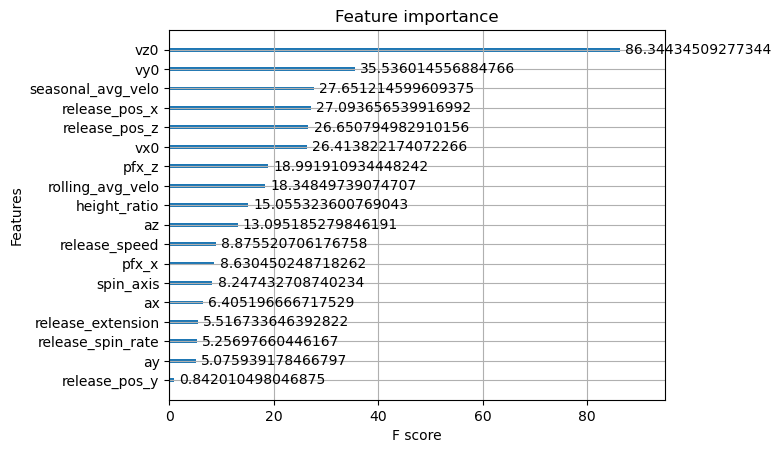

In [ ]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

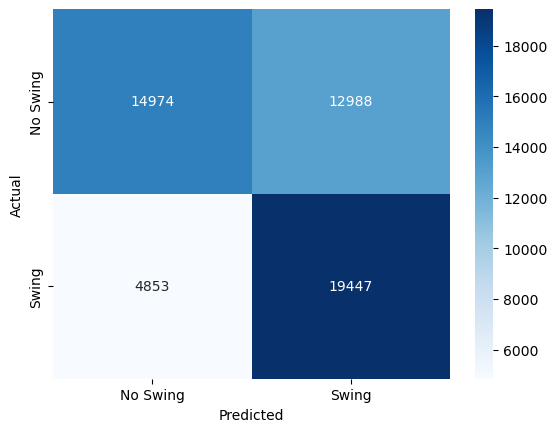

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo'],
      dtype='object')

In [ ]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [ ]:
y_pred = final_model.predict(predictions)

In [ ]:
testing_identifiers['xswing'] = y_pred

In [ ]:
num_nans = testing_identifiers['xswing'].isna().sum()
print(f"Number of NaNs in 'xswing': {num_nans}")

Number of NaNs in 'xswing': 0


In [ ]:
len(testing_identifiers)

562083

In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/fastball/swing_2022&3_xswing.csv")